<a href="https://colab.research.google.com/github/Lemuca09/FuzzyLogic/blob/main/FuzzyPrecos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


## **Fuzzificação**

O objetivo deste projeto é criar um **Sistema Fuzzy de Satisfação do Cliente**, que recebe três variáveis de entrada:

1. **Tempo de Entrega (0 a 72 horas)**
2. **Preço (1 a 100 unidades)**
3. **Qualidade (0 a 10)**

E produz uma única saída:

- **Satisfação (0 a 10)**

O funcionamento segue a lógica fuzzy tradicional:

1. **Fuzzificação:** converte cada valor real em graus de pertinência (entre 0 e 1).
2. **Inferência:** ativa regras do tipo **SE (... ) ENTÃO (... )**.
3. **Agregação:** combina as regras ativadas.
4. **Defuzzificação:** transforma o resultado nebuloso em um número real (centroide).

Matematicamente, toda pertinência μ é sempre:

$$
0 \le \mu \le 1
$$

E a saída final é calculada via:

$$
\text{Satisfação} = \frac{\int x \cdot \mu(x) \, dx}{\int \mu(x) \, dx}
$$

(Defuzzificação por **centroid**.)

###Criamos um conjunto de dados com **200 exemplos** para testar o sistema fuzzy.  
Os valores são gerados aleatoriamente dentro de intervalos definidos:

- Tempo de entrega:
$$
  \text{tempo} \sim U(1, 72)
$$

- Preço:
$$
  \text{preço} \sim U(1, 100)
$$

- Qualidade:
$$
  \text{qualidade} \sim U(0, 10)
$$

Onde $$U(a, b)$$ representa a distribuição uniforme no intervalo $$([a, b])$$

Cada linha forma um caso realista a ser avaliado pelo sistema fuzzy.


In [51]:
n = 200

# Dataset simulado com tempo de entrega, preço e qualidade
data = pd.DataFrame({
    'tempo_entrega': np.random.uniform(1, 72, n), # Em Horas
    'preco': np.random.uniform(1, 100, n),
    'qualidade': np.random.uniform(0, 10, n)
})

In [52]:
tempo = ctrl.Antecedent(np.arange(1, 73, 1), 'tempo_entrega') # Chega em até 72 horas
preco = ctrl.Antecedent(np.arange(1, 101, 1), 'preco')
qualidade = ctrl.Antecedent(np.arange(0, 11, 1), 'qualidade')
satisfacao = ctrl.Consequent(np.arange(0, 11, 1), 'satisfacao')

###Criar funções com trapézio:

A função trapézio é:

$$
\mu(x) =
\begin{cases}
0, & x \le a \\
\dfrac{x-a}{b-a}, & a < x \le b \\
1, & b < x \le c \\
\dfrac{d-x}{d-c}, & c < x < d \\
0, & x \ge d
\end{cases}
$$

Motivação:

- Criar áreas planas onde a pertinência é **100% (μ=1)**.
- Reduzir transições bruscas.
- Melhorar estabilidade do sistema.


### Por que utilizamos a função trapezoidal e não a triangular ou gaussiana?

Usamos a função **trapezoidal (trapmf)** para os conjuntos que representam *Máximos* e *Mínimos* porque:

- Ela permite representar uma região onde o grau de pertinência é **totalmente 1 por um intervalo inteiro**, e não apenas em um único ponto (como aconteceria com a triangular).
- No problema de tempo de entrega, valores acima de um limite (ex.: 48 minutos) devem ser considerados **totalmente lentos** até o máximo do universo (72 minutos).  
- A função triangular não serviria, pois ela só atinge pertinência plena em **um único ponto**.
- A função gaussiana não serviria porque não possui regiões planas de pertinência 1, e é mais adequada para conjuntos onde a transição deve ser totalmente suave, não abrupta como no tempo de entrega.

In [53]:
tempo['rápido'] = fuzz.trapmf(tempo.universe, [1, 1, 24, 36])
tempo['moderado'] = fuzz.trimf(tempo.universe, [24, 36, 48])
tempo['lento'] = fuzz.trapmf(tempo.universe, [36, 48, 72, 72])

preco['baixo'] = fuzz.trapmf(preco.universe, [1, 1, 35, 55])
preco['médio'] = fuzz.trimf(preco.universe, [35, 55, 75])
preco['alto'] = fuzz.trapmf(preco.universe, [55, 75, 100, 100])

qualidade['ruim'] = fuzz.trapmf(qualidade.universe, [0, 0, 3, 5])
qualidade['média'] = fuzz.trimf(qualidade.universe, [3, 5, 7])
qualidade['excelente'] = fuzz.trapmf(qualidade.universe, [5, 7, 10, 10])

satisfacao['baixa'] = fuzz.trapmf(satisfacao.universe, [0, 0, 2, 5])
satisfacao['média'] = fuzz.trimf(satisfacao.universe, [3, 5, 7])
satisfacao['alta']  = fuzz.trapmf(satisfacao.universe, [5, 8, 10, 10])



### Usamos funções triangulares para os valores moderados exatamente por ter a característica de pico e rápida variação linear.

Definidas matematicamente como:

$$
\mu(x) =
\begin{cases}
0, & x \le a \\
\dfrac{x-a}{b-a}, & a < x \le b \\
\dfrac{c-x}{c-b}, & b < x < c \\
0, & x \ge c
\end{cases}
$$


### Cálculo do grau de pertinência para `x = 43` utilizando a função de pertinência trapezoidal

$$
a = 36,\quad b = 48,\quad c = 72,\quad d = 72
$$

Nesse caso, o intervalo de subida ocorre quando:

$$
36 < x < 48
$$

Como estamos calculando o grau de pertinência para **x = 43**, aplicamos a parte crescente da função:

$$
\mu_{\text{lento}}(43) = \frac{43 - 36}{48 - 36}
$$

Cálculo numérico:

$$
\mu_{\text{lento}}(43) = \frac{7}{12} \approx 0.5833
$$



Assim, a função trapezoidal é adequada porque modela corretamente:

- um **início gradual** (36 → 48)
- uma **região totalmente lenta** (48 → 72)




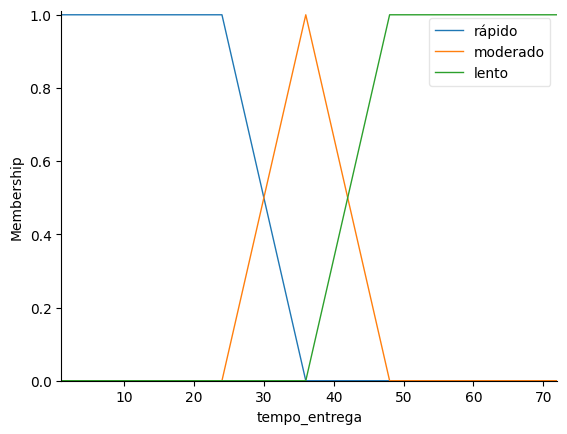

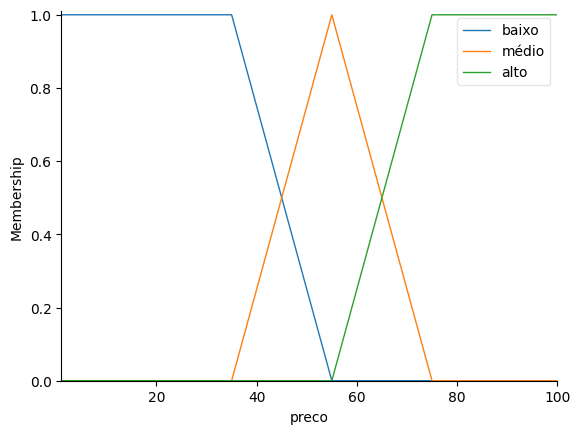

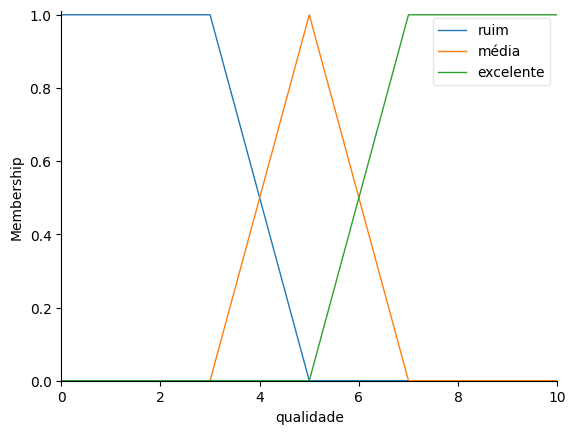

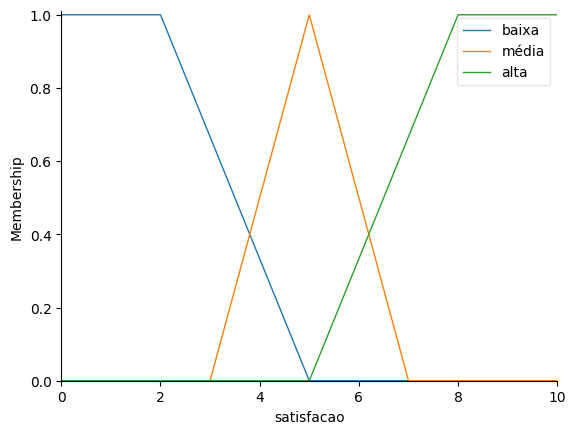

In [54]:
tempo.view()
preco.view()
qualidade.view()
satisfacao.view()

###As regras seguem a estrutura:

$$
\text{SE condições ENTÃO saída}
$$

### Regras usadas

1. SE qualidade = excelente **E** preço = baixo  
   ENTÃO satisfação = alta

2. SE qualidade = ruim **OU** preço = alto  
   ENTÃO satisfação = baixa

3. SE tempo = lento **E** qualidade = média  
   ENTÃO satisfação = média

4. SE tempo = rápido **E** qualidade = excelente  
   ENTÃO satisfação = alta

5. SE tempo = lento **E** preço = alto  
   ENTÃO satisfação = baixa

6. SE tempo = moderado **E** preço = médio **E** qualidade = média  
   ENTÃO satisfação = média

### Operadores

- AND → mínimo:  
  $$
  \mu_{A \land B} = \min(\mu_A, \mu_B)
  $$

- OR → máximo:  
$$
  \mu_{A \lor B} = \max(\mu_A, \mu_B)
$$


In [55]:
rule1 = ctrl.Rule(qualidade['excelente'] & preco['baixo'], satisfacao['alta'])  # Se, então
rule2 = ctrl.Rule(qualidade['ruim'] | preco['alto'], satisfacao['baixa'])
rule3 = ctrl.Rule(tempo['lento'] & qualidade['média'], satisfacao['média'])
rule4 = ctrl.Rule(tempo['rápido'] & qualidade['excelente'], satisfacao['alta'])
rule5 = ctrl.Rule(tempo['lento'] & preco['alto'], satisfacao['baixa'])
rule6 = ctrl.Rule(tempo['moderado'] & preco['médio'] & qualidade['média'], satisfacao['média'])

In [56]:
satisfacao_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
satisfacao_simulador = ctrl.ControlSystemSimulation(satisfacao_ctrl)

while True:
    tempo_val = float(input('Digite o tempo de entrega (0 a 72 horas): '))
    if tempo_val < 0 or tempo_val > 72:
        print('O tempo deve estar entre 0 a 72 horas.')
        continue
    satisfacao_simulador.input['tempo_entrega'] = tempo_val
    break

while True:
    preco_val = float(input('Digite o preço (1 a 100): '))
    if preco_val < 1 or preco_val > 100:
        print('O preço deve estar entre 1 e 100.')
        continue
    satisfacao_simulador.input['preco'] = preco_val
    break

while True:
    qualidade_val = float(input('Digite a qualidade (0 a 10): '))
    if qualidade_val < 0 or qualidade_val > 10:
        print('A qualidade deve estar entre 0 e 10.')
        continue
    satisfacao_simulador.input['qualidade'] = qualidade_val
    break

Digite o tempo de entrega (0 a 72 horas): 30
Digite o preço (1 a 100): 20
Digite a qualidade (0 a 10): 6


## 6 — Defuzzificação pelo Método do Centroide

Após a ativação das regras, as áreas fuzzy da saída são agregadas.<br>
Obtém-se uma forma fuzzy final, que não é um número, mas uma forma geométrica com alturas, larguras e inclinações.<br><br>

Como as áreas finais costumam ser assimétricas, o centroide (Center of Area) se posicionará onde há mais área.<br><br>


O objetivo da defuzzificação é transformar essa forma fuzzy em um valor numérico único (crisp).

O valor final (crisp) é calculado por:

$$
s = \frac{\int x \cdot \mu(x) \, dx}{\int \mu(x) \, dx}
$$
Interpretando:

* Numerador: soma de todos os valores ${x}$ ponderados por sua pertinência  ${\mu(x)}$.

* Denominador: área total da forma fuzzy.



Nível de Satisfação do Cliente: 7.85 Estrelas

Nível de Satisfação do Cliente: Excelente


    tempo_entrega      preco  qualidade
0       54.618902  52.993507   8.588631
1       58.679159  74.608969   9.953136
2       37.179974  53.155731   3.641070
3       39.655974  44.452269   7.441285
4       46.040681  50.627440   8.005586
5       71.979542  94.636774   9.531806
6       51.437688  78.272067   4.345493
7       29.939816  49.471283   0.955186
8       51.432373  19.221725   0.349446
9        5.084428  32.735350   2.769218
10      59.256715  21.102541   6.158963
11      44.558899  50.688925   9.876803
12      34.918531  78.278078   4.056418
13       7.584127  70.380844   0.800484
14      63.877647  15.562603   1.095734
15      46.948595  43.299596   4.781649
16      39.936681   6.061383   9.799974
17      45.079011  43.471643   3.030841
18      20.321420  32.447893   6.478537
19       4.176702  41.733495   4.563905


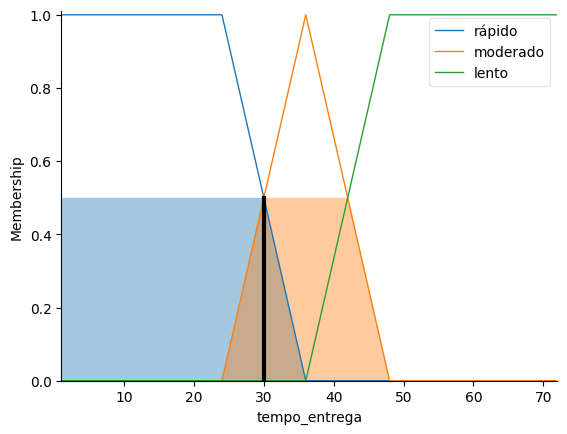

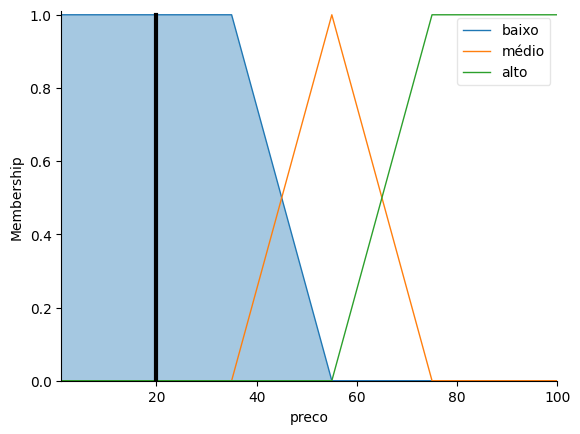

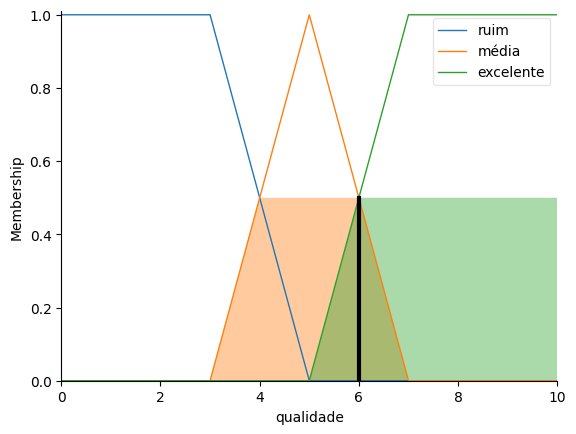

In [57]:
satisfacao_simulador.compute() # Defuzzificação

print('\nNível de Satisfação do Cliente: {:.2f} Estrelas'.format(satisfacao_simulador.output['satisfacao']))

satfis = satisfacao_simulador.output['satisfacao']

if satfis >= 7:
  print('\nNível de Satisfação do Cliente: Excelente')
elif satfis >= 5:
  print('\nNível de Satisfação do Cliente: Boa')
elif satfis >= 3:
  print('\nNível de Satisfação do Cliente: Ruim')
else:
  print('\nNível de Satisfação do Cliente: Péssima')
print("\n")

tempo.view(sim=satisfacao_simulador)
preco.view(sim=satisfacao_simulador)
qualidade.view(sim=satisfacao_simulador)
# satisfacao.view(sim=satisfacao_simulador)

print(data.head(20))

### Gráficos gerados:

1. **Scatter 2D:**  
   - qualidade × satisfação_fuzzy  
   - cor = preço  

2. **Scatter 2D:**  
   - tempo × satisfação_fuzzy  
   - cor = preço  

3. **Gráfico 3D:**  
   \[
   (tempo,\; qualidade,\; satisfação)
   \]

Esses gráficos permitem visualizar relações como:
  
- Preços maiores tendem a puxar a satisfação ↓  
- Entregas lentas afetam negativamente dependendo das regras.


In [58]:
#Gerar dados para o gráfico scatter

satisfacoes = []

for i, row in data.iterrows():
    sim = ctrl.ControlSystemSimulation(satisfacao_ctrl)
    sim.input['tempo_entrega'] = float(row['tempo_entrega'])
    sim.input['preco'] = float(row['preco'])
    sim.input['qualidade'] = float(row['qualidade'])

    try:
        sim.compute() # Deffuzificação
        satisfacoes.append(sim.output['satisfacao'])
    except KeyError:
        satisfacoes.append(np.nan)
    except Exception as e:
        print(f"Erro na linha {i}: {e}")
        satisfacoes.append(np.nan)

data['satisfacao_fuzzy'] = satisfacoes

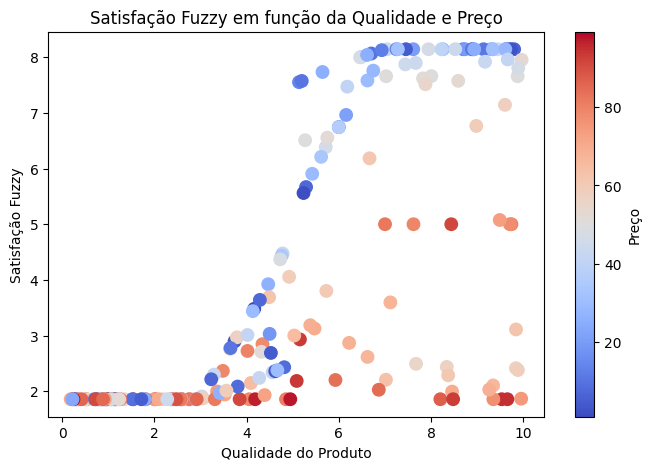

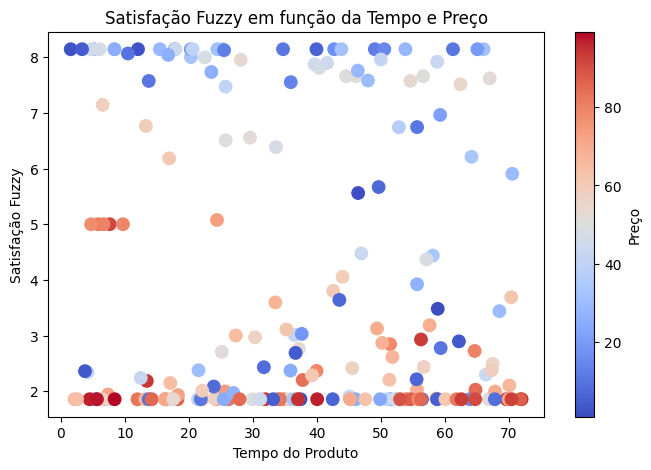

In [59]:
# Satisfação -> Qualidade x Preço

plt.figure(figsize=(8, 5))
plt.scatter(data['qualidade'], data['satisfacao_fuzzy'], c=data['preco'], cmap='coolwarm', s=80)
plt.colorbar(label='Preço')
plt.title('Satisfação Fuzzy em função da Qualidade e Preço')
plt.xlabel('Qualidade do Produto')
plt.ylabel('Satisfação Fuzzy')
plt.show()

# Satisfação -> Tempo x Preço

plt.figure(figsize=(8, 5))
plt.scatter(data['tempo_entrega'], data['satisfacao_fuzzy'], c=data['preco'], cmap='coolwarm', s=80)
plt.colorbar(label='Preço')
plt.title('Satisfação Fuzzy em função da Tempo e Preço')
plt.xlabel('Tempo do Produto')
plt.ylabel('Satisfação Fuzzy')
plt.show()


In [60]:
fig = px.scatter_3d(
    data,
    x='qualidade',
    y='tempo_entrega',
    z='satisfacao_fuzzy',
    color='preco',
    color_continuous_scale='RdYlBu_r',
    size_max=10,
    title='Satisfação Fuzzy em função da Qualidade, Tempo e Preço'
)

fig.update_layout(
    scene=dict(
        xaxis_title='Qualidade do Produto',
        yaxis_title='Tempo de Entrega (h)',
        zaxis_title='Satisfação Fuzzy'
    ),
    coloraxis_colorbar=dict(title='Preço')
)

fig.show()

In [61]:
tempo['rápido'] = fuzz.trimf(tempo.universe, [1, 1, 35])
tempo['moderado'] = fuzz.trimf(tempo.universe, [20, 35, 50])
tempo['lento'] = fuzz.trimf(tempo.universe, [35, 72, 72])

preco['baixo'] = fuzz.trimf(preco.universe, [1, 1, 50])
preco['médio'] = fuzz.trimf(preco.universe, [30, 50, 70])
preco['alto'] = fuzz.trimf(preco.universe, [50, 100, 100])

qualidade['ruim'] = fuzz.trimf(qualidade.universe, [0, 0, 5])
qualidade['média'] = fuzz.trimf(qualidade.universe, [3, 5, 7])
qualidade['excelente'] = fuzz.trimf(qualidade.universe, [5, 10, 10])

satisfacao['baixa'] = fuzz.trimf(satisfacao.universe, [0, 0, 5])
satisfacao['média'] = fuzz.trimf(satisfacao.universe, [3, 5, 7])
satisfacao['alta'] = fuzz.trimf(satisfacao.universe, [5, 10, 10])

In [62]:
rule1 = ctrl.Rule(qualidade['excelente'] & preco['baixo'], satisfacao['alta'])
rule2 = ctrl.Rule(qualidade['ruim'] | preco['alto'], satisfacao['baixa'])
rule3 = ctrl.Rule(tempo['lento'] & qualidade['média'], satisfacao['média'])
rule4 = ctrl.Rule(tempo['rápido'] & qualidade['excelente'], satisfacao['alta'])
rule5 = ctrl.Rule(tempo['lento'] & preco['alto'], satisfacao['baixa'])
rule6 = ctrl.Rule(tempo['moderado'] & preco['médio'] & qualidade['média'], satisfacao['média'])

Digite o tempo de entrega (0 a 72 horas): 30
Digite o preço (1 a 100): 20
Digite a qualidade (0 a 10): 6

Nível de Satisfação do Cliente: 7.74 Estrelas


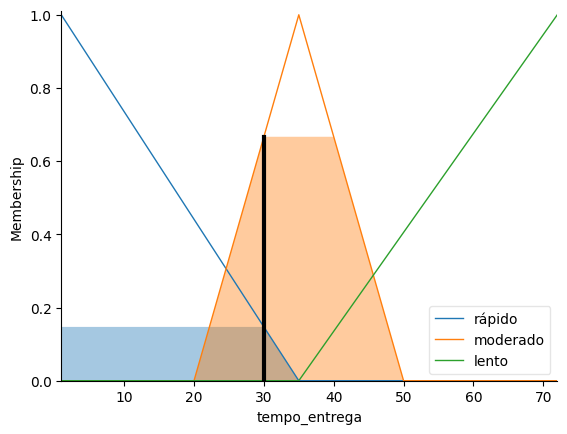

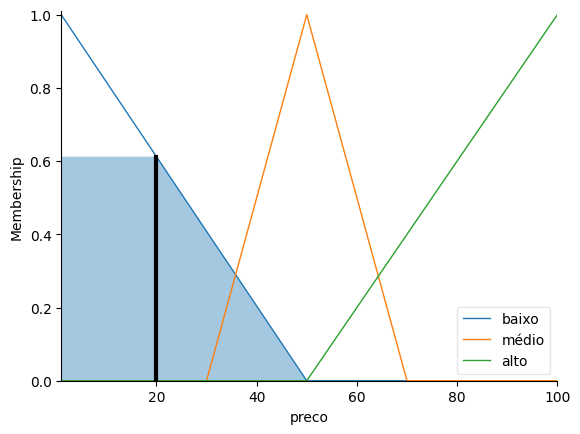

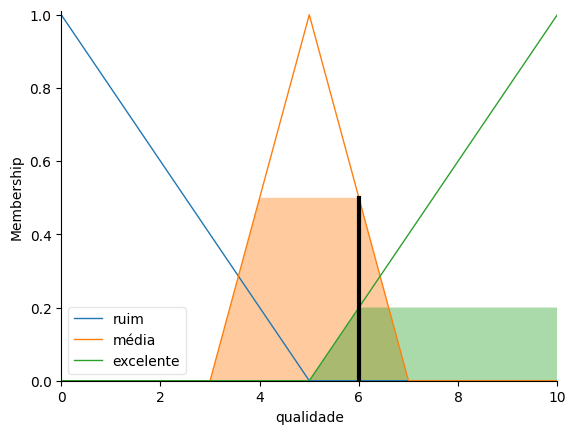

In [63]:
sistema_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema = ctrl.ControlSystemSimulation(sistema_ctrl)

while True:
    tempo_val = float(input('Digite o tempo de entrega (0 a 72 horas): '))
    if tempo_val < 0 or tempo_val > 72:
        print('O tempo deve estar entre 0 a 72 horas.')
        continue
    satisfacao_simulador.input['tempo_entrega'] = tempo_val
    break

while True:
    preco_val = float(input('Digite o preço (1 a 100): '))
    if preco_val < 1 or preco_val > 100:
        print('O preço deve estar entre 1 e 100.')
        continue
    satisfacao_simulador.input['preco'] = preco_val
    break

while True:
    qualidade_val = float(input('Digite a qualidade (0 a 10): '))
    if qualidade_val < 0 or qualidade_val > 10:
        print('A qualidade deve estar entre 0 e 10.')
        continue
    satisfacao_simulador.input['qualidade'] = qualidade_val
    break

sistema.compute()

print('\nNível de Satisfação do Cliente: {:.2f} Estrelas'.format(sistema.output['satisfacao']))

tempo.view(sim=sistema)
preco.view(sim=sistema)
qualidade.view(sim=sistema)
# satisfacao.view(sim=sistema)